## Not done yet ,
in this notebook , Catgan unsupervised and semi supervised is implemented and applied to mnist data

 https://arxiv.org/abs/1511.06390


In [ ]:
# Importer les librairies de Python 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical # 

import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.python.training import moving_averages
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from tensorflow.keras.datasets import mnist

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('pas de GPU')
print('GPU est: {}'.format(device_name))

print('Version de Tensorflow', tf.__version__)

GPU est: /device:GPU:0
Version de Tensorflow 2.4.1


In [ ]:
NB_LABELED  = 100 # nombre de données labellisées
INPUT_SHAPE  = 128 # la dimension de l'entree du générateur
# les dimensions des images
HEIGHT = 28
WIDTH  = 28
# Le paramètre de la fonction leaky_relu
LEAK_ALPHA = 0.1
NB_PER_CLASS = NB_LABELED//10
LABELS = 10

In [ ]:
# Récupérer les données
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Ajouter la dimension du canal et normalisation vers [0,1]
X_train = np.expand_dims(X_train , axis = -1).astype('float64')/255.0 # (0,1)
X_test  = np.expand_dims(X_test , axis = -1).astype('float64')/255.0

# normalisation vers [-1,1], parce que la sortie du générateur peut être négatif
X_train = (X_train - 0.5)/0.5
X_test = (X_test - 0.5)/0.5

# extraire 10 exemples de chaque chiffre
X_100 = np.zeros((NB_LABELED,HEIGHT,WIDTH,1))
y_100 = np.zeros(NB_LABELED)
idx_labaled = np.array([]).astype('int')
for i in range(LABELS):
  Item_index = np.where(y_train==i)[0]
  np.random.seed(44)
  INDEX_PER_CLASS = np.random.choice(list(Item_index),NB_PER_CLASS , replace = False)
  X_100[i*NB_PER_CLASS:(i+1)*NB_PER_CLASS,:,:,:] = X_train[INDEX_PER_CLASS,:,:]
  y_100[i*NB_PER_CLASS:(i+1)*NB_PER_CLASS] = y_train[INDEX_PER_CLASS,]
  idx_labaled = np.concatenate((idx_labaled,np.array(INDEX_PER_CLASS)))

y_100 = to_categorical(y_100 , num_classes = LABELS)

# supprimer les 100 exemples labellisées.
X_train = np.delete(X_train, idx_labaled, axis=0)


In [ ]:
np.unique(y_train,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [ ]:
print('X_train shap' , X_train.shape)
print('y_train shap' , y_train.shape)

X_train shap (59900, 28, 28, 1)
y_train shap (60000,)


In [ ]:
# filter_shape est de la forme [filter_height, filter_width, in_channels, out_channels]
def weights(filter_shape , name ):
    w = tf.get_variable(name, shape = filter_shape,initializer=tf.random_normal_initializer(0, 0.1))
    return w

# shape_ est de la forme [out_channels]
def bias(shape_ , name):
    b = tf.get_variable(name, shape = shape_ ,initializer=tf.random_normal_initializer(1, 0.5))
    return b

# Couche de convolution avec un activation
def Conv2D_Block(x, W, bias, padding='SAME', activation='relu' , name='conv2d' , strides = [1,1]):
  with tf.variable_scope(name):
    output = tf.nn.conv2d(x, W, strides=[1, *strides, 1], padding = padding) + bias
    if activation=='leakyrelu':
      return tf.nn.leaky_relu(output, alpha = LEAK_ALPHA)
    elif activation=='sigmoid' :
      return tf.nn.sigmoid(output)
    elif activation=='tanh' :
      return tf.nn.tanh(output)

    else :
      return output

# Couche d'upsampling avec des zeros sur les bords du volume d'entrée.
def UpSampling2D_Zeros(x , strides = (2,2)):
  x_shape = x.get_shape()
  h1 = x_shape[1] // strides[0]
  h2 = x_shape[2] // strides[1]
  paddings = tf.constant([[0,0] ,[h1 ,h1] , [h2,h2] , [0,0]])
  return tf.pad(x,paddings, mode='constant')

# Couche de Max-Pooling
def Max_pool2D(x , strides = (2,2) , kernel_size = (3,3)):
    return tf.nn.max_pool(x, ksize=[1, *kernel_size, 1], strides=[1, *strides, 1], padding='SAME')

# Couche de Batch-Normalization
def batch_norm_layer(x,is_training=True,reuse=True,scope='BatchNormalization' , decay=0.85):
  bn = tf.layers.batch_normalization(x , momentum = decay, training=is_training ,reuse=reuse,name=scope)
  return bn
  #return tf.keras.layers.GaussianNoise(stddev = 0.05)(bn,training=is_training)

In [ ]:
# Generateur :
# input_x est l'entrée du générateur.
# reuse est un booléen qui indique de réutiliser un générateur du même nom dans le graphe.
# training est un booléen qui indique le statut du réseau (entraînement ou inférence)
def Generator(input_x ,reuse=False, training=True, name ="Generator" ):
    with tf.variable_scope(name, reuse=reuse):
      W_fc = weights([INPUT_SHAPE , 8 * 8 * 96 ] , 'kernel_1')
      b_fc = bias([8 * 8 * 96], 'bias_1')
      h_fc = tf.nn.leaky_relu(tf.matmul(input_x, W_fc) + b_fc , alpha = LEAK_ALPHA)
      h_fc = batch_norm_layer(h_fc , scope='bn1', is_training = training , reuse = reuse , decay = 0.9)

      img_0 = tf.reshape(h_fc, [-1, 8, 8, 96])
      h_t1 = UpSampling2D_Zeros(img_0)
      W_t1 = weights([3, 3, 96 , 96] , 'kernel_2')
      b_t1 = bias([96], 'bias_2')
      h_t1 = Conv2D_Block(h_t1, W_t1, b_t1, activation='leakyrelu', name='conv-1')
      h_t1 = batch_norm_layer(h_t1 ,scope='bn2', is_training =training, reuse = reuse , decay = 0.9 )

###########
      W_t1 = weights([5, 5, 96 , 96] , 'kernel_3')
      b_t1 = bias([96], 'bias_3')
      h_t1 = Conv2D_Block(h_t1, W_t1, b_t1, activation='leakyrelu', name='conv-2')
      h_t1 = batch_norm_layer(h_t1 ,scope='bn3', is_training =training, reuse = reuse , decay = 0.9 )
##########
      W1 = weights([5, 5, 96 , 64], 'kernel_4')
      b1 = bias([64], 'bias_4')
      h1 = Conv2D_Block(h_t1, W1, b1, activation='leakyrelu', name='conv-3')
      h1 = batch_norm_layer(h1,scope='bn4',is_training =training,reuse=reuse,decay = 0.9)

      h_t2 = UpSampling2D_Zeros(h1) # 
      W_t2 = weights([3, 3, 64 , 64] , 'kernel_5')
      b_t2 = bias([64] , 'bias_5')
      h_t2 = Conv2D_Block(h_t2, W_t2, b_t2, activation='leakyrelu', name='conv-4')
      h_t2 = batch_norm_layer(h_t2,scope='bn222',is_training =training,reuse=reuse,decay=0.9)
###########
      W_t2 = weights([3, 3, 64 , 64] , 'kernel_6')
      b_t2 = bias([64], 'bias_6')
      h_t2 = Conv2D_Block(h_t2, W_t2, b_t2, activation='leakyrelu', name='conv-5')
      h_t2 = batch_norm_layer(h_t2 ,scope='bn6', is_training =training, reuse = reuse , decay = 0.9 )
##########
      W2 = weights([5, 5, 64, 64] , 'kernel_7')
      b2 = bias([64], 'bias_7')
      h2 = Conv2D_Block(h_t2, W2, b2 , padding='VALID',activation='leakyrelu', name='conv-6')
      h2 = batch_norm_layer(h2 ,  scope='bn7', is_training =training, reuse = reuse , decay = 0.9 )

      W3 = weights([1, 1, 64, 1]  , 'kernel_8')
      b3 = bias([1] , 'bias_8')
      h3 = Conv2D_Block(h2, W3, b3 , padding='VALID',activation='tanh', name='conv-7')
    return h3



# Discriminateur :
# input_x est l'entrée du Discriminateur.
# reuse est un booléen qui indique de réutiliser un Discriminateur du même nom dans le graphe.
# training est un booléen qui indique le statut du réseau (entraînement ou inférence)
def Discriminator(input_x ,reuse=False , training=True , name="Discriminator"):
    with tf.variable_scope(name , reuse=reuse):
      W0 = weights([5, 5, 1, 32] , 'kernel_d_1')
      b0 = bias([32], 'bias_d_1')
      h0 = Conv2D_Block(input_x, W0, b0, activation='leakyrelu', name='conv-1' , strides = [2,2])
      h0 = batch_norm_layer(h0 ,  scope='bn_d1', is_training =training , reuse = reuse , decay = 0.9)

      h_pool = Max_pool2D(h0 , strides=(2,2),kernel_size=(3,3))
      #h_pool = h0

      W1 = weights([3, 3, 32, 64] , 'kernel_d_2')
      b1 = bias([64], 'bias_d_2')
      h1 = Conv2D_Block(h_pool, W1, b1, activation='leakyrelu', name='conv-2')
      h1 = batch_norm_layer(h1 ,  scope='bn_d2', is_training =training , decay = 0.9 , reuse = reuse)

      W2 = weights([3, 3, 64, 64] , 'kernel_d_3')
      b2 = bias([64], 'bias_d_3')
      h2 = Conv2D_Block(h1, W2, b2, activation='leakyrelu', name='conv-3' , strides = [2,2])
      h2 = batch_norm_layer(h2 ,  scope='bn_d3', is_training =training , decay = 0.9 , reuse = reuse)

      h_pool_1 = Max_pool2D(h2 , strides=(2,2),kernel_size=(3,3))
      #h_pool_1 = h2
      W3 = weights([3, 3, 64, 128] , 'kernel_d_4')
      b3 = bias([128] , 'bias_d_4')
      h3 = Conv2D_Block(h_pool_1, W3, b3, activation='leakyrelu', name='conv-4')
      h3 = batch_norm_layer(h3 ,  scope='bn_d4', is_training =training , decay = 0.9 , reuse = reuse)

      W4 = weights([1, 1, 128, 10] , 'kernel_d_5')
      b4 = bias([10] , 'bias_d_5')
      h4 = Conv2D_Block(h3, W3,  b3, activation='leakyrelu', name='conv-5')
      h4 = batch_norm_layer(h4 ,  scope='bn_d5', is_training =training , decay = 0.9 , reuse = reuse)

      h4_shape  = h4.get_shape()
      h_flattened = tf.reshape(h4, [-1, h4_shape[1] *h4_shape[2]*h4_shape[3]])
      
      W_fc = weights([h_flattened.get_shape()[1], 128] , 'kernel_d_6')
      b_fc = bias([128], 'bias_d_6')
      h_fc = tf.nn.leaky_relu(tf.matmul(h_flattened, W_fc) + b_fc , alpha = LEAK_ALPHA)
      h_fc = batch_norm_layer(h_fc ,  scope='bn_d6', is_training =training , decay = 0.9 , reuse = reuse)

      W_fc_out = weights([128, LABELS] , 'kernel_d_7')
      b_fc_out = bias([LABELS], 'bias_d_7')
      logits = tf.matmul(h_fc, W_fc_out) + b_fc_out
      probs  = tf.nn.softmax(logits , axis= -1)
    return logits,probs

In [ ]:
from sklearn.metrics import accuracy_score
LAMBDA = 1
DATA_SIZE = X_train.shape[0]
BATCH_SIZE = 100 
Epsilon = 1e-7
tf.reset_default_graph()

with tf.device('/gpu:0'):
  # mettre en place les PlaceHolders pour les entrées du graphes
  is_training = tf.placeholder(tf.bool, [] , name = "is_training")

  noise_input = tf.placeholder(tf.float32, shape = [None, INPUT_SHAPE] , name = 'nois_input') # Loi uniforme
  X_input   = tf.placeholder(tf.float32, shape = [None, HEIGHT, WIDTH, 1], name = 'X_input') # Non-labelisee
  X_labeled = tf.placeholder(tf.float32, shape = [None, HEIGHT, WIDTH, 1], name = 'X_labeled')
  y_input   = tf.placeholder(tf.float32, shape = [None, LABELS], name = 'y_input')

  # Générateur va prendre du bruit et génère un échantillon
  generated_sample = Generator(noise_input, training = is_training)

  # Discriminateur va faire un prédiction sur les données réelles non labellisées et les données générées
  real_logits, d_real  = Discriminator(X_input, training = is_training)
  fake_logits, d_fake  = Discriminator(generated_sample, reuse = True, training = is_training)

  # Construction de la fonction de perte du Discriminator :
  entropy_d_real = tf.reduce_mean(d_real , 0)
  H_x_y_D  = - tf.reduce_sum(entropy_d_real * tf.log(entropy_d_real + Epsilon))# +1e-6 pour éviter que d_real soit nul
  E_H_fake = - tf.reduce_sum(d_fake * tf.log(d_fake + Epsilon))/BATCH_SIZE
  E_H_real = - tf.reduce_sum(d_real * tf.log(d_real + Epsilon))/BATCH_SIZE
 
  # Construction de la partie supervisée de la fonction de perte du Discriminateur :
  real_logits_labaled, d_real_labeled = Discriminator(X_labeled, reuse = True, training = is_training) 
  E_H_real_0 = - tf.reduce_sum(d_real_labeled * tf.log(d_real_labeled + Epsilon))/100
  CE_y_real  = - tf.reduce_sum(y_input * tf.log(d_real_labeled + Epsilon) , reduction_indices=[1])
  cost =  tf.reduce_mean(CE_y_real)
  d_loss = - H_x_y_D + E_H_real + E_H_real_0 - E_H_fake + LAMBDA * cost # disc loss
  
  # Construction de la fonction de perte du Générateur :
  entropy_d_fake = tf.reduce_mean(d_fake , 0)
  H_x_y_G =  - tf.reduce_sum(entropy_d_fake * tf.log(entropy_d_fake + Epsilon))
  g_loss  =  - H_x_y_G + E_H_fake

  # Le taux d'apprentissage 
  lr = 2e-4
  d_optimizer = tf.train.AdamOptimizer(learning_rate = lr)# , beta1 = 0.5 , beta2 = 0.9)
  g_optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4)# , beta1 = 0.5 , beta2 = 0.9)  

  # Récupérer les variables de chaque réseau séparément
  # Récupérer les variables de la couche Batch-normalization parce qu'ils 
  # ne sont pas enregistrées dans tf.GraphKeys.TRAINABLE_VARIABLES
  gen_vars     = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Generator') 
  g_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope = 'Generator') 
  train_gen    = tf.group([g_optimizer.minimize(g_loss, var_list = gen_vars) , g_update_ops]) 

  disc_vars    = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Discriminator')
  d_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope = 'Discriminator')
  train_disc   = tf.group([d_optimizer.minimize(d_loss, var_list = disc_vars) , d_update_ops])

  predictions = tf.argmax(d_real,axis=1 , name='predictions')
  
  init = tf.global_variables_initializer()
  sess = tf.Session() 
  sess.run(init)

  # Le graphe est sauvegardée sur TensorBoard
  writer = tf.summary.FileWriter('logs')
  writer.add_graph(sess.graph)

  D_loss_tab = [] 
  G_loss_tab = []
  ACC = []
  for i in range(30):
    for j in range(DATA_SIZE//BATCH_SIZE):
      start_index = j*BATCH_SIZE 
      end_index = (j+1) * BATCH_SIZE
      if j == DATA_SIZE//BATCH_SIZE-1 : 
        start_index = DATA_SIZE - BATCH_SIZE 
        end_index   = DATA_SIZE

      batch_xs = X_train[start_index:end_index]
        
      noise_z   = np.random.uniform(-1,1,INPUT_SHAPE * BATCH_SIZE).reshape((BATCH_SIZE,INPUT_SHAPE))
      feed_dict = {noise_input: noise_z ,
                    X_input   : batch_xs,
                    X_labeled : X_100   ,
                    y_input   : y_100   , is_training: True}

      sess.run([train_disc , train_gen], feed_dict = feed_dict)
    if i%5 == 0:
        feed_dict = {X_input: X_test, is_training : False }
          
        predd = sess.run(predictions, feed_dict = feed_dict)
        ACC.append(np.mean(y_test == predd))
        print('epoch : ',i, ' // accuracy', accuracy_score(y_test,predd) ,'--')

    feed_dict = {noise_input: noise_z ,
                    X_input   : batch_xs,
                    X_labeled : X_100   ,
                    y_input   : y_100   , is_training: False}
          
    gl,dl = sess.run([g_loss,d_loss], feed_dict = feed_dict)
    G_loss_tab.append(gl)
    D_loss_tab.append(dl)

epoch :  0  // accuracy 0.7865 --
epoch :  5  // accuracy 0.852 --
epoch :  10  // accuracy 0.8971 --
epoch :  15  // accuracy 0.9385 --
epoch :  20  // accuracy 0.949 --
epoch :  25  // accuracy 0.9532 --


In [ ]:
xx = X_test
yy = y_test
y_eval = sess.run(predictions ,feed_dict = {X_input : xx, is_training : False})

print(yy)
print(y_eval)
print(np.mean(y_eval== yy)*100)
print('accuracy 1 ' , accuracy_score(y_eval , y_test))
print(np.unique(yy[y_eval==8], return_counts=True))

[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]
95.52000000000001
accuracy 1  0.9552
(array([1, 2, 3, 4, 6, 7, 8, 9], dtype=uint8), array([  2,   4,   1,   1,  11,   2, 903,   5]))


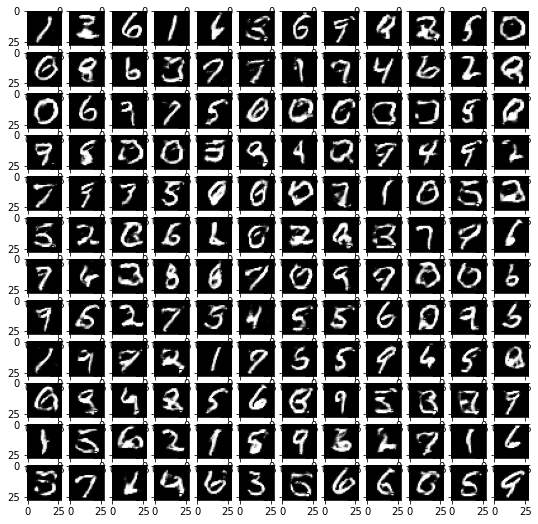

In [ ]:
nb = 12
z = np.random.uniform(-1,1,INPUT_SHAPE * nb * nb).reshape((nb * nb,INPUT_SHAPE))
gkk = sess.run(generated_sample , feed_dict={is_training:False , noise_input :z})

fig, axs = plt.subplots(nb, nb , figsize = (9,9))
for i in range(nb):
  for j in range(nb):
    ip = i*nb + j
    axs[i,j].imshow((gkk[ip,:,:,0]*127.5+127.5).astype('uint8'), cmap = plt.cm.gray)
    #ax2.imshow( (gkk[1,:,:,0]*127.5+127.5).astype('uint8'), cmap =plt.cm.gray)
plt.show()

In [ ]:
sess.close()

In [ ]:
BATCH_SIZE = 100
Epsilon = 1e-7
tf.reset_default_graph()

with tf.device('/gpu:0'):
  is_training = tf.placeholder(tf.bool, [] , name = "is_training")
  noise_input  = tf.placeholder(tf.float32, shape=[None, INPUT_SHAPE] , name = 'nois_input')
  X_input  = tf.placeholder(tf.float32, shape=[None, HEIGHT, WIDTH, 1], name = 'X_input')

  generated_sample = Generator(noise_input, training = is_training)

  real_logits, d_real  = Discriminator(X_input, training = is_training)  
  fake_logits, d_fake  = Discriminator(generated_sample, reuse = True, training = is_training)

  entropy_d_real = tf.reduce_mean(d_real , 0)
  H_x_y_D   = - tf.reduce_sum(entropy_d_real * tf.log(entropy_d_real + Epsilon)) 
  E_H_fake =  - tf.reduce_sum(d_fake * tf.log(d_fake + Epsilon))/BATCH_SIZE
  E_H_real =  - tf.reduce_sum(d_real * tf.log(d_real + Epsilon))/BATCH_SIZE
 
  d_loss =  - H_x_y_D  + E_H_real - E_H_fake 
  
  entropy_d_fake = tf.reduce_mean(d_fake , 0)
  H_x_y_G =  - tf.reduce_sum(entropy_d_fake * tf.log(entropy_d_fake + Epsilon))
  g_loss  =  - H_x_y_G + E_H_fake

  lr = 2e-4
  d_optimizer = tf.train.AdamOptimizer(learning_rate = lr)
  g_optimizer = tf.train.AdamOptimizer(learning_rate = lr) 

  
  gen_vars     = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Generator')
  g_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope = 'Generator')
  train_gen    = tf.group([g_optimizer.minimize(g_loss, var_list = gen_vars) , g_update_ops])

  disc_vars    = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Discriminator')
  d_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope = 'Discriminator')
  train_disc   = tf.group([d_optimizer.minimize(d_loss, var_list = disc_vars) , d_update_ops])

  predictions = tf.argmax(d_real,axis=1)
  
  init =  tf.global_variables_initializer()
  sess =  tf.Session() 
  sess.run(init)

  writer = tf.summary.FileWriter('logs')
  writer.add_graph(sess.graph)

  D_loss_tab = [] 
  G_loss_tab = []
  for i in range(20):
    DATA_SIZE = X_train.shape[0]
    for j in range(DATA_SIZE//BATCH_SIZE):
      start_index = j*BATCH_SIZE 
      end_index = (j+1) * BATCH_SIZE
      if j == DATA_SIZE//BATCH_SIZE-1 : 
        start_index = DATA_SIZE - BATCH_SIZE 
        end_index   = DATA_SIZE

      batch_xs = X_train[start_index:end_index]
      noise_z   = np.random.uniform(0,1,INPUT_SHAPE * BATCH_SIZE).reshape((BATCH_SIZE,INPUT_SHAPE))
      
      feed_dict = {noise_input : noise_z,
                   X_input : batch_xs, 
                   is_training: True}
      sess.run([train_disc , train_gen], feed_dict = feed_dict)

In [ ]:
y_eval = sess.run(predictions ,feed_dict = {X_input : X_test, is_training : False})

print(np.unique(y_eval , return_counts = True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1140,  915,  733, 1046,  732, 1224, 1477,  896,  920,  917]))
